In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from utils import *
from model import *

c:\python36\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
left = tf.placeholder(tf.float32, [None, 100, 100, 3], name='left')
right = tf.placeholder(tf.float32, [None, 100, 100, 3], name='right')

label = tf.placeholder(tf.int32, [None, 1], name='label') # 1 if same, 0 if different
label = tf.to_float(label)

margin = 1

left_output = mynet(left, reuse=False)
right_output = mynet(right, reuse=True)

loss = contrastive_loss(left_output, right_output, label, margin)
optim = tf.train.AdamOptimizer(0.0005).minimize(loss)

init_op = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init_op)

(?, 100, 100, 3)
(?, 86, 86, 32)
(?, 43, 43, 32)
(?, 36, 36, 64)
(?, 12, 12, 64)
(?, 8, 8, 256)
(?, 4, 4, 256)
(?, 4096)
(?, 64)
(?, 100, 100, 3)
(?, 86, 86, 32)
(?, 43, 43, 32)
(?, 36, 36, 64)
(?, 12, 12, 64)
(?, 8, 8, 256)
(?, 4, 4, 256)
(?, 4096)
(?, 64)


In [3]:
test_image_paths = []
for category in os.listdir(photo_path):
    category_path = os.path.join(photo_path, category + '/')
    image_paths = np.random.choice(os.listdir(category_path), size=20, replace=False)
    for i in range(20):
        test_image_paths.append(category_path + image_paths[i])
np.random.shuffle(test_image_paths)
len(np.unique(test_image_paths))

2500

In [4]:
test_sketch_path = sketch_path + np.random.choice(os.listdir(sketch_path)) 
test_sketch_path = test_sketch_path + '/' + np.random.choice(os.listdir(test_sketch_path))
test_sketch_path

'Sketchy/sketch/bell/n03028596_5727-4.png'

In [5]:
test_sketch = load_img(test_sketch_path)
test_sketch = np.expand_dims(test_sketch, 0)
test_sketch.shape

(1, 100, 100, 3)

In [6]:
test_images = []
for path in test_image_paths:
    test_images.append(load_img(path))
test_images = np.array(test_images)
test_images.shape

(2500, 100, 100, 3)

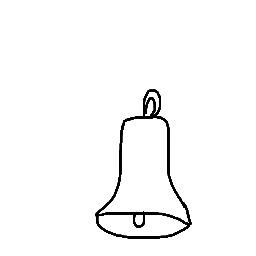

In [7]:
from PIL import Image
Image.open(test_sketch_path)

In [ ]:
for epoch in range(1000000):
    photo_dictionary, sketch_dictionary = get_dict()
    p_batch, s_batch, lab_batch = get_batch(photo_dictionary, sketch_dictionary)
    lab_batch = lab_batch.reshape(-1, 1)
    [_, loss_] = sess.run([optim,loss], {left: p_batch, right: s_batch, label:lab_batch})
    
    
    if epoch%100==0:
        
        sketch_repr = sess.run([left_output], {left: test_sketch})
        sketch_repr = np.squeeze(np.array(sketch_repr), 1)
        print(sketch_repr.shape)
        sketch_representations = np.tile(sketch_repr, 2496).reshape(2496, 64)
        print(sketch_representations.shape)
        
        batch_size = 8
        n_batches = len(test_images) // batch_size
        image_representations = []

        for i in range(n_batches):
            img_repr = sess.run([left_output], {left: test_images[i*batch_size : (i+1)*batch_size]})
            img_repr = np.squeeze(np.array(img_repr), 0)
            image_representations.append(img_repr)
        image_representations = np.vstack(image_representations)

        diff = np.sqrt(np.mean((sketch_representations - image_representations)**2, -1))
        top_k = np.argsort(diff)[:5]

        print ('##' + str(epoch) + ' : loss == ' + str(loss_))

        plt.figure(figsize=(20, 20))
        for i in range(5):    
            img = mpimg.imread(test_image_paths[top_k[i]])
            plt.subplot(1, 5, i+1)
            plt.imshow(img)
            plt.xticks([])
            plt.yticks([])
        plt.show()